### this notebook implements the code from https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5


Sets up final layer for resnet 18 pretrained

Some edits:
- rain_dir -> train_dir (typo)
- it seems I ran a larger set of images than described in the paper


different directory structure:

base_dir = '/Users/shannon/science/courses/SciProgramming_FA23/'

train_dir = os.path.join(base_dir,'data_torch','train')

test_dir =  os.path.join(base_dir,'data_torch','test')

Image class labels are taken from directory they are inside of.

In [1]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check version of Pytorch
print(torch. __version__)

2.1.0


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

False

In [6]:
#### dirs from original article
# seems not all are used (e.g., onlyl rain_dir (sp?) and test_dir


# Set up path for data after downloading
# rain_dir = "C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/train/"
# test_dir = "C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/test/"
# train_classa_dir = "C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/train/benign/"
# train_classb_dir = "C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/train/malignant/"
# test_classa_dir = "C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/test/benign/"
# test_classb_dir = "C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/test/malignant/"

In [37]:
base_dir = '/Users/shannon/science/courses/SciProgramming_FA23/'

train_dir = os.path.join(base_dir,'data_torch','train')

test_dir =  os.path.join(base_dir,'data_torch','test')

```python
# Display image for reference
white_torch = torchvision.io.read_image('C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/test/benign/1.jpg')
print("This is benign skin cancer")
T.ToPILImage()(white_torch)
```

In [14]:
white_torch = torchvision.io.read_image(os.path.join(test_dir,'benign','1.jpg'))
print("This is benign skin cancer")
# T.ToPILImage()(white_torch)

This is benign skin cancer


The next loading seems wrong as it reads from benign directory...

```python
# Display image for reference
wh = torchvision.io.read_image('C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/test/benign/44.jpg')
print("This is malignant skin cancer")
T.ToPILImage()(wh)
```

In [13]:
# Display image for reference
wh = torchvision.io.read_image(os.path.join(test_dir,'malignant','1.jpg'))
print("This is malignant skin cancer")
# T.ToPILImage()(wh)

This is malignant skin cancer


Because Resnet accepts input image sizes of (224 * 224), the image must be resized to be (224 * 224), preprocessing for our data, which entails random horizontal flip, rotation, normalization, etc., needs to be defined at first.

In [15]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [17]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 2077
Test dataset size: 660
Class names: ['benign', 'malignant']


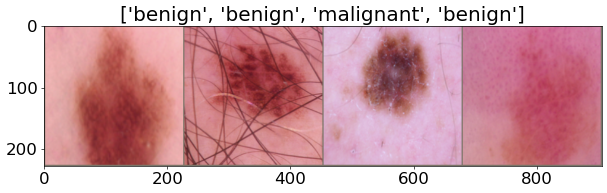

In [18]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
    
    
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [21]:
for i,x in enumerate(train_dataloader):
    
    if i < 2:
        print(x)
        print('-------')
    
    

[tensor([[[[ 1.3242,  1.3584,  1.3584,  ...,  1.3413,  1.3070,  1.2728],
          [ 1.3413,  1.3242,  1.3413,  ...,  1.3242,  1.2899,  1.2557],
          [ 1.3755,  1.3242,  1.3242,  ...,  1.3070,  1.2728,  1.2385],
          ...,
          [ 1.8208,  1.8208,  1.8208,  ...,  1.3070,  1.3242,  1.3755],
          [ 1.8208,  1.8037,  1.7694,  ...,  1.3242,  1.3413,  1.3755],
          [ 1.8037,  1.7523,  1.7180,  ...,  1.3584,  1.3413,  1.3927]],

         [[ 0.5028,  0.5553,  0.5903,  ...,  0.5903,  0.5553,  0.5728],
          [ 0.5378,  0.5378,  0.5553,  ...,  0.6078,  0.5553,  0.5553],
          [ 0.6078,  0.5553,  0.5378,  ...,  0.6078,  0.5553,  0.5378],
          ...,
          [ 1.1856,  1.2031,  1.1856,  ...,  0.5378,  0.5728,  0.6254],
          [ 1.2206,  1.2031,  1.1856,  ...,  0.5728,  0.5903,  0.6429],
          [ 1.2556,  1.2206,  1.1856,  ...,  0.6254,  0.5728,  0.6604]],

         [[ 1.1934,  1.2457,  1.3154,  ...,  1.1585,  1.1585,  1.1759],
          [ 1.2631,  1.2282, 

In [27]:
x[1]

tensor([0])

In [28]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


As we can see, there are 512 output features from the original model; therefore, we need to change this by adding a fully connected layer for our classification problem with only 2 target classes.

In [30]:
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

Freezing the base model for training

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False. This will be conducted when we train our model.

4. Train model
As we have a customized classifier for our cancer problem, now we start to train our model.

To begin training, we define loss function and an optimizer first.

We’ll use Cross-Entropy loss for the loss function and SGD with momentum and lr=0.0001.

In [31]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [32]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Again, due to computer limitation, the author only runs 30 epochs for each set and saves the result of loss and accuracy in lists for further use.

In [33]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)

# Start loop

for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
            
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0456 Acc: 72.4121% Time: 58.7887s
[Test #1] Loss: 0.0369 Acc: 80.0000% Time: 65.8744s
Epoch 1 running
[Train #2] Loss: 0.0370 Acc: 79.2008% Time: 123.9686s
[Test #2] Loss: 0.0338 Acc: 81.5152% Time: 130.9757s
Epoch 2 running
[Train #3] Loss: 0.0355 Acc: 79.3934% Time: 188.8250s
[Test #3] Loss: 0.0320 Acc: 82.1212% Time: 195.9529s
Epoch 3 running
[Train #4] Loss: 0.0345 Acc: 80.5007% Time: 254.0661s
[Test #4] Loss: 0.0305 Acc: 83.3333% Time: 261.1174s
Epoch 4 running
[Train #5] Loss: 0.0332 Acc: 80.4526% Time: 319.4111s
[Test #5] Loss: 0.0296 Acc: 83.3333% Time: 326.5470s
Epoch 5 running
[Train #6] Loss: 0.0313 Acc: 81.8970% Time: 385.1057s
[Test #6] Loss: 0.0304 Acc: 82.1212% Time: 392.2942s
Epoch 6 running
[Train #7] Loss: 0.0307 Acc: 82.3303% Time: 452.7234s
[Test #7] Loss: 0.0288 Acc: 85.1515% Time: 459.8482s
Epoch 7 running
[Train #8] Loss: 0.0301 Acc: 83.8228% Time: 518.5234s
[Test #8] Loss: 0.0305 Acc: 81.3636% Time: 525.4126s
Epoch 8 running
[T

In [38]:
# We must now save our trained model for testing and future use.

save_dir = os.path.join(base_dir,'models_torch')
save_name = 'custom-classifier_resnet_18_final.pth'
torch.save(model.state_dict(), os.path.join(save_dir,save_name))

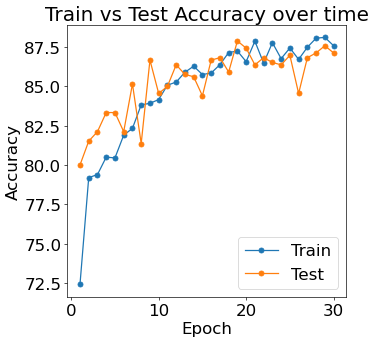

In [39]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

5.2. Class performance
To check the performance of each class, the author draws a confusion matrix and heatmap plot for observation.

In [40]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

Accuracy on Training set:  0.8712121212121212
Confusion matrix: 
 [[9570 1230]
 [1320 7680]]
Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     10800
           1       0.86      0.85      0.86      9000

    accuracy                           0.87     19800
   macro avg       0.87      0.87      0.87     19800
weighted avg       0.87      0.87      0.87     19800



<AxesSubplot:title={'center':'Confusion matrix for Skin Cancer classification '}>

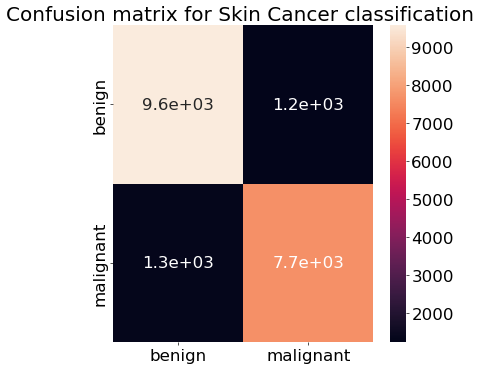

In [41]:
# Visualization and result
# constant for classes
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True)